In [1]:
# export PYTHONPATH="${PYTHONPATH}:/uio/kant/geo-geofag-u1/franzihe/Documents/Python/globalsnow/CloudSat_ERA5_CMIP6_analysis/utils/"

# Example with CloudSat 


# Table of Contents
<ul>
<li><a href="#introduction">1. Introduction</a></li>
<li><a href="#data_wrangling">2. Data Wrangling</a></li>
<li><a href="#exploratory">3. Exploratory Data Analysis</a></li>
<li><a href="#conclusion">4. Conclusion</a></li>
<li><a href="#references">5. References</a></li>
</ul>

# 1. Introduction <a id='introduction'></a>
Cloud feedbacks are a major contributor to the spread of climate sensitivity in global climate models (GCMs) ([Zelinka et al. (2020)](https://doi-org.ezproxy.uio.no/10.1029/2019GL085782)]). Among the most poorly understood cloud feedbacks is the one associated with the cloud phase, which is expected to be modified with climate change ([Bjordal et al. (2020)](https://doi-org.ezproxy.uio.no/10.1038/s41561-020-00649-1)). Cloud phase bias, in addition, has significant implications for the simulation of radiative properties and glacier and ice sheet mass balances in climate models. 

In this context, this work aims to expand our knowledge on how the representation of the cloud phase affects snow formation in GCMs. Better understanding this aspect is necessary to develop climate models further and improve future climate predictions. 

* Load ERA5 data previously downloaded locally via [Jupyter Notebook - download ERA5](https://github.com/franzihe/download_ERA5)
* find clouds: liquid-only, ice-only, mixed-phase
* Regridd the ERA5 variables to the same horizontal resolution as high-resolution CMIP6 models with [`xesmf`](https://xesmf.readthedocs.io/en/latest/)
* Calculate and plot the seasonal mean of the variable

**Questions**
* How is the cloud phase and snowfall varying between 1985 and 2014?


> **_NOTE:_** We answer questions related to the comparison of CMIP models to ERA5 in another [Jupyter Notebook](../CMIP6_ERA5_CloudSat/plt_seasonal_mean.ipynb).

# 2. Data Wrangling <a id='data_wrangling'></a>

This study will compare surface snowfall, ice, and liquid water content from the Coupled Model Intercomparison Project Phase 6 ([CMIP6](https://esgf-node.llnl.gov/projects/cmip6/)) climate models (accessed through [Pangeo](https://pangeo.io/)) to the CloudSat data from **2007 to 2010**, excluding September 2008 and December 2009 (insufficient CALIOP data and CloudSat battery failure, see McIllhattan et al. 2017). We conduct statistical analysis at the annual and seasonal timescales to determine the biases in cloud phase and precipitation (liquid and solid) in the CMIP6 models and their potential connection between them. The CMIP6 data analysis can be found in the [Jupyter Notebook for CMIP6](../cmip/CMIP6_hr_1985-2014.ipynb).

- Time period: 2007 to 2010
- horizonal nominal resolution: ~250km
- time resolution: monthly data 
- Variables:

| shortname     |             Long name                                       |      Units    |  levels |
| ------------- |:-----------------------------------------------------------:| -------------:|--------:|
| n_obs         |Totoal number of observations ('satellite profiles'), all-sky|| |
| n_cld         |Total number of cloudy observations                          |            |  |
| n_lcc         |Total number of observations with supercooled liquid cloud (any 'mixed' or 'liquid' flag within profile)       |       |   |
| lcc_freq      |n_lcc / n_obs       |       |   |
| n_sf_all      |all profiles with confident snowfall (sf >0)          |       |   |
| n_sf_all_snow |all profiles with confident snowfall above 0.01 mm/h               |       |   |
| n_sf_lcc      |all profiles with supercooled liquid cloud and confident snowfall (sf >0) | |
| n_sf_lcc_snow | all profiles with supercooled liquid cloud and confident snowfall above 0.01 mm/h | |
| sf_avg_all    | average surface snowfall (mm/h) corresponding to n_sf_all | |
| sf_avg_all_snow | average surface snowfall (mm/h) corresponding to n_sf_all_snow | |
| sf_avg_lcc    | average surface snowfall (mm/h) corresponding to n_sf_lcc ||
| sf_avg_lcc_snow | average surface snowfall (mm/h) corresponding to n_sf_lcc_snow ||
| lcc_sf_freq    | n_sf_lcc_snow / n_lcc ||

## Organize my data

- Define a prefix for my project (you may need to adjust it for your own usage on your infrastructure).
    - input folder where all the data used as input to my Jupyter Notebook is stored (and eventually shared)
    - output folder where all the results to keep are stored
    - tool folder where all the tools

The CloudSat data is located in the folder `/input/cloudsat/` and have the format `cc_sf_lcc_{year}_{month}.nc`.


In [2]:
import os
import pathlib
import sys
import socket
hostname = socket.gethostname()

abs_path = str(pathlib.Path(hostname).parent.absolute())
WORKDIR = abs_path[:- (len(abs_path.split('/')[-2] + abs_path.split('/')[-1])+1)]


if "mimi" in hostname:
    print(hostname)
    DATA_DIR = "/mn/vann/franzihe/"
    # FIG_DIR = "/uio/kant/geo-geofag-u1/franzihe/Documents/Figures/ERA5/"
    FIG_DIR = "/uio/kant/geo-geofag-u1/franzihe/Documents/Python/globalsnow/CloudSat_ERA5_CMIP6_analysis/Figures/CloudSat/"
elif "glefsekaldt" in hostname: 
    DATA_DIR = "/home/franzihe/Data/"
    FIG_DIR = "/home/franzihe/Documents/Figures/CloudSat/"

INPUT_DATA_DIR = os.path.join(DATA_DIR, 'input')
OUTPUT_DATA_DIR = os.path.join(DATA_DIR, 'output')
UTILS_DIR = os.path.join(WORKDIR, 'utils')

sys.path.append(UTILS_DIR)
# make figure directory
try:
    os.mkdir(FIG_DIR)
except OSError:
    pass

mimi.uio.no


## Import python packages
- `Python` environment requirements: file [requirements_globalsnow.txt](../../requirements_globalsnow.txt) 
- load `python` packages from [imports.py](../../utils/imports.py)
- load `functions` from [functions.py](../../utils/functions.py)


In [3]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
from imports import(xr, intake, ccrs, cy, plt, glob, cm, fct, np, da, LogNorm, pd, datetime, xe)
xr.set_options(display_style='html')

In [4]:
# reload imports
%load_ext autoreload
%autoreload 2

## Open ERA5 variables
Get the data requried for the analysis. Beforehand we downloaded the monthly averaged data on single levels and pressure levels via the Climate Data Store (CDS) infrastructure. The github repository [Download ERA5](https://github.com/franzihe/download_ERA5) gives examples on how to download the data from the CDS. We use the Jupyter Notebooks [download_Amon_single_level](https://github.com/franzihe/download_ERA5/blob/main/download_Amon_single_level.ipynb) and [download_Amon_pressure_level](https://github.com/franzihe/download_ERA5/blob/main/download_Amon_pressure_level.ipynb). Both, download the monthly means for the variables mentioned above between 1985 and 2014.

> **_NOTE:_** To download from CDS a user has to have a CDS user account, please create the account [here](https://cds.climate.copernicus.eu/user/register).


In [5]:
cs_in = os.path.join(INPUT_DATA_DIR, 'cloudsat/')
cmip_in = os.path.join(INPUT_DATA_DIR, 'cmip6_hist/single_model')

cs_out = os.path.join(OUTPUT_DATA_DIR, 'CS_ERA5_CMIP6/')
# make output data directory
try:
    os.mkdir(cs_out)
except OSError:
    pass

In [6]:
# # needed for regridding ERA5 data to CMIP6 grids
# cmip_in = os.path.join(INPUT_DATA_DIR, 'cmip6_hist/single_model')


At the moment we have downloaded 4 years (2007 - 2010) for CloudSat. We define start and end year to ensure to only extract the 4-year period between 2007 and 2010.

$\rightarrow$ Define a start and end year

We will load all available variables into one xarray dataset with `xarray.open_mfdataset(file)` and select the time range [by name](https://xarray.pydata.org/en/stable/user-guide/indexing.html).

In [7]:
# rsync -av --progress login.nird-lmd.sigma2.no:/projects/NS9600K/tcarlsen/18_Global_Snow_Study/output_files/sf_lcc_monthly/ /scratch/franzihe/input/cloudsat/
# /projects/NS9600K/tcarlsen/18_Global_Snow_Study/output_files/sf_lcc_monthly_T_thres_all_coarse

In [8]:
starty = 2007
endy = 2010
year_range = range(starty, endy + 1)


# Uncomment the line below if you want to search for files matching the pattern in the directory specified by `cs_in`
# cs_file_in = glob(f'{cs_in}/*_cs5_*.nc')
# cs_file_in = sorted(glob(f'{cs_in}/40NS/*_cs5_*.nc'))
# cs_file_in = []
# cs_file_in.extend(sorted(glob(f'{cs_in}/sf_lcc_monthly/cc_sf_lcc_2007_01.nc')))
# cs_file_in.extend(sorted(glob(f'{cs_in}/sf_lcc_monthly{input_file}/cc_sf_lcc_2007_01{input_file}.nc')))

# ds_cs = xr.open_mfdataset(cs_file_in, )
# Uncomment the line below if you want to rename the variable `t2m` to `2t`
# ds_cs = ds_cs.rename_vars({'t2m': '2t'})

# ds_cs = ds_cs.sel(time=ds_cs.time.dt.year.isin(year_range)).squeeze()

# ds_cs = ds_cs.assign_coords(lon=(((ds_cs.lon + 180) % 360) - 180)).sortby(['lon', 'time'])



In [9]:
def add_time_dim_and_attributes(ds, ds_cs, year, month):
    # add time dimension
    ds = ds.expand_dims(time=pd.to_datetime([f'{year}-{month}']))
            
    # #assign attributes to variables
    ds['n_obs'] = ds['n_obs'].assign_attrs({'long_name':'Total number of observations ("satellite profiles"), all-sky', 'units': ''})
    ds['n_cld'] = ds['n_cld'].assign_attrs({'long_name':'Total number of cloudy observations', 'units': ''})
    ds['n_lcc'] = ds['n_lcc'].assign_attrs({'long_name':'Total number of observations with supercooled liquid cloud (any "mixed" or "liquid" flag within profile)', 'units': ''})
    ds['lcc_freq'] = ds['lcc_freq'].assign_attrs({'long_name':'n_lcc / n_obs', 'units': ''})
    ds['n_sf_all'] = ds['n_sf_all'].assign_attrs({'long_name':'all profiles with confident snowfall (sf >0)', 'units': ''})
    ds['n_sf_all_snow'] = ds['n_sf_all_snow'].assign_attrs({'long_name':'all profiles with confident snowfall above 0.01 mm/h', 'units': ''})
    ds['n_sf_lcc'] = ds['n_sf_lcc'].assign_attrs({'long_name':'all profiles with supercooled liquid cloud and confident snowfall (sf >0)', 'units': ''})
    ds['n_sf_lcc_snow'] = ds['n_sf_lcc_snow'].assign_attrs({'long_name':'all profiles with supercooled liquid cloud and confident snowfall above 0.01 mm/h', 'units': ''})
    ds['sf_avg_all'] = ds['sf_avg_all'].assign_attrs({'long_name':'average surface snowfall (mm/h) corresponding to n_sf_all', 'units': '(mm h-1)'})
    ds['sf_avg_all_snow'] = ds['sf_avg_all_snow'].assign_attrs({'long_name':'average surface snowfall (mm/h) corresponding to n_sf_all_snow', 'units': '(mm h-1)'})
    ds['sf_avg_lcc'] = ds['sf_avg_lcc'].assign_attrs({'long_name':'average surface snowfall (mm/h) corresponding to n_sf_lcc', 'units': '(mm h-1)'})
    ds['sf_avg_lcc_snow'] = ds['sf_avg_lcc_snow'].assign_attrs({'long_name':'average surface snowfall (mm/h) corresponding to n_sf_lcc_snow',
                                                                'units': '(mm h-1)'})
    ds['lcc_sf_freq'] = ds['lcc_sf_freq'].assign_attrs({'long_name':'n_sf_lcc_snow / n_lcc', 'units': ''})
    
    ds_cs = xr.merge([ds_cs, ds])
    
    return(ds_cs)

In [10]:
# ds_cs       = xr.Dataset()
# ds_cs_orig  = xr.Dataset()
ds_cs_all = xr.Dataset()
ds_cs_orig_all = xr.Dataset()


for year in year_range:
    for month in np.arange(1,13):
        # print(f'{year}-{month}-16')
        # cs_file_in = []
        # cs_orig_in = []
        cs_file_in_all = []
        cs_orig_all = []
        
        if month < 10:
            # cs_file_in.extend(sorted(glob(f'{cs_in}/sf_lcc_monthly/cc_sf_lcc_{year}_0{month}.nc')))
            # cs_orig_in.extend(sorted(glob(f'{cs_in}/sf_lcc_monthly_no_T_thres/cc_sf_lcc_{year}_0{month}_no_T_thres.nc')))
            # cs_file_in_all.extend(sorted(glob(f'{cs_in}/sf_lcc_monthly_T_thres_all/cc_sf_lcc_{year}_0{month}_T_thres_all.nc')))
            cs_file_in_all.extend(sorted(glob(f'{cs_in}/sf_lcc_monthly_T_thres_all_coarse/cc_sf_lcc_{year}_0{month}_T_thres_all_coarse.nc')))
            cs_orig_all.extend(sorted(glob(f'{cs_in}/sf_lcc_monthly_no_T_thres_all_coarse/cc_sf_lcc_{year}_0{month}_no_T_thres_all_coarse.nc')))
        else:
            # cs_file_in.extend(sorted(glob(f'{cs_in}/sf_lcc_monthly/cc_sf_lcc_{year}_{month}.nc')))
            # cs_orig_in.extend(sorted(glob(f'{cs_in}/sf_lcc_monthly_no_T_thres/cc_sf_lcc_{year}_{month}_no_T_thres.nc')))
            cs_file_in_all.extend(sorted(glob(f'{cs_in}/sf_lcc_monthly_T_thres_all_coarse/cc_sf_lcc_{year}_{month}_T_thres_all.nc')))
            cs_orig_all.extend(sorted(glob(f'{cs_in}/sf_lcc_monthly_no_T_thres_all_coarse/cc_sf_lcc_{year}_{month}_no_T_thres_all_coarse.nc')))
        # if len(cs_file_in) != 0:
        #     ds      = xr.open_mfdataset(cs_file_in, )
        #     ds_cs       = add_time_dim_and_attributes(ds, ds_cs)
        # if len(cs_orig_in) != 0:
        #     ds_orig = xr.open_mfdataset(cs_orig_in)
        #     ds_cs_orig  = add_time_dim_and_attributes(ds_orig, ds_cs_orig)
        if len(cs_file_in_all) != 0:
            ds_all = xr.open_mfdataset(cs_file_in_all)
            ds_cs_all = add_time_dim_and_attributes(ds_all, ds_cs_all, year, month)
        if len(cs_orig_all) != 0:
            ds_orig_all = xr.open_mfdataset(cs_orig_all)
            ds_cs_orig_all = add_time_dim_and_attributes(ds_orig_all, ds_cs_orig_all, year, month)
            

try: 
    # ds_cs = ds_cs.drop([np.datetime64('2008-09'), np.datetime64('2009-12')], dim='time')  
    # ds_cs_orig = ds_cs_orig.drop([np.datetime64('2008-09'), np.datetime64('2009-12')], dim='time') 
    ds_cs_all = ds_cs_all.drop([np.datetime64('2008-09'), np.datetime64('2009-12')], dim='time') 
    ds_cs_orig_all = ds_cs_orig_all.drop([np.datetime64('2008-09'), np.datetime64('2009-12')], dim='time')
except:
    print('datetime64("2008-09") and datetime64("2009-12") not found in axis') 
         
        

datetime64("2008-09") and datetime64("2009-12") not found in axis


## Change attributes matching CMIP6 data

We will assign the attributes to the variables to make CMIP6, ERA5, and CloudSat variables comperable.

* [`snowfall_rate_sf`] is in **mm h-1** $\rightarrow$  multiply by **1000kg / 1000 m3** to get **kg m-2 h-1** .





In [11]:
# In this optimized version, you define a dictionary conversion_factors that maps each variable ID (var_id) 
# to its corresponding conversion factor and attributes. The code then iterates over the keys of the dataset 
# ds_cs and checks if the variable ID exists in the conversion_factors dictionary. If it does, it retrieves 
# the conversion factor and attributes for that variable and performs the necessary operations.

conversion_factors = {
    'sf_avg_all': {'factor': 1000./1000., 'attrs': {'units': 'kg m-2 h-1', 'long_name': 'average surface snowfall corresponding to n_sf_all'}},
    'sf_avg_all_snow': {'factor': 1000./1000., 'attrs': {'units': 'kg m-2 h-1', 'long_name': 'average surface snowfall corresponding to n_sf_all_snow'}},
    'sf_avg_lcc': {'factor': 1000./1000., 'attrs': {'units': 'kg m-2 h-1', 'long_name': 'average surface snowfall corresponding to n_sf_lcc'}},
    'sf_avg_lcc_snow': {'factor': 1000./1000., 'attrs': {'units': 'kg m-2 h-1', 'long_name':'average surface snowfall corresponding to n_sf_lcc_snow'}},
}


for var_id in ds_cs_all.keys():
    if var_id in conversion_factors:
        factor = conversion_factors[var_id]['factor']
        attrs = conversion_factors[var_id]['attrs']

        # ds_cs[var_id] = ds_cs[var_id] * factor
        # ds_cs[var_id].attrs = attrs
        # ds_cs[var_id] = ds_cs[var_id].where(ds_cs[var_id] >= 0., other=np.nan)
        
        # ds_cs_orig[var_id] = ds_cs_orig[var_id] * factor
        # ds_cs_orig[var_id].attrs = attrs
        # ds_cs_orig[var_id] = ds_cs_orig[var_id].where(ds_cs_orig[var_id] >= 0., other=np.nan)
        
        ds_cs_all[var_id] = ds_cs_all[var_id] * factor
        ds_cs_all[var_id].attrs = attrs
        ds_cs_all[var_id] = (ds_cs_all[var_id].where(ds_cs_all[var_id] >= 0., other=np.nan)).astype(np.float64())
        
        ds_cs_orig_all[var_id] = ds_cs_orig_all[var_id] * factor
        ds_cs_orig_all[var_id].attrs = attrs
        ds_cs_orig_all[var_id] = (ds_cs_orig_all[var_id].where(ds_cs_orig_all[var_id] >= 0., other=np.nan)).astype(np.float64())


In [12]:
for var_id in ds_cs_all.keys():
        print(var_id, ds_cs_all[var_id].attrs['units'], ds_cs_orig_all[var_id].attrs['units'])




lcc_freq  
n_obs  
n_cld  
n_lcc  
n_sf_all  
n_sf_all_snow  
n_sf_lcc  
n_sf_lcc_snow  
lcc_sf_freq  
sf_avg_all kg m-2 h-1 kg m-2 h-1
sf_avg_all_snow kg m-2 h-1 kg m-2 h-1
sf_avg_lcc kg m-2 h-1 kg m-2 h-1
sf_avg_lcc_snow kg m-2 h-1 kg m-2 h-1


## Regrid to 500km nominal resolution

In [13]:
# model = 'IPSL-CM5A2-INCA'
# variable_id = ['areacella']
# cmip_file_in = glob(f'{cmip_in}/{model}/{variable_id[0]}_fx_*{model}*.nc')

# ds_cmip = xr.open_dataset(cmip_file_in[0], )#drop_variables=variable_id[0])

# # Shift longitude to be from -180 to 180
# ds_cmip = ds_cmip.assign_coords(lon=(((ds_cmip['lon'] + 180) % 360) - 180)).sortby('lon')

# cs_in_grid      = fct.regrid_data(ds_cs, ds_cmip)
# cs_in_grid_orig = fct.regrid_data(ds_cs_orig, ds_cmip)
# cs_in_grid_all = fct.regrid_data(ds_cs_all, ds_cmip)
# cs_in_grid_orig_all = fct.regrid_data(ds_cs_orig_all, ds_cmip)


In [14]:
fslcc = (ds_cs_all['n_lcc']/ds_cs_orig_all['n_obs']).groupby('time.season').mean('time',skipna=True).fillna(0.)
flcc = (ds_cs_orig_all['n_lcc']/ds_cs_orig_all['n_obs']).groupby('time.season').mean('time',skipna=True).fillna(0.)

In [15]:
hemisphere = 'SH'
lat_extent = 45.

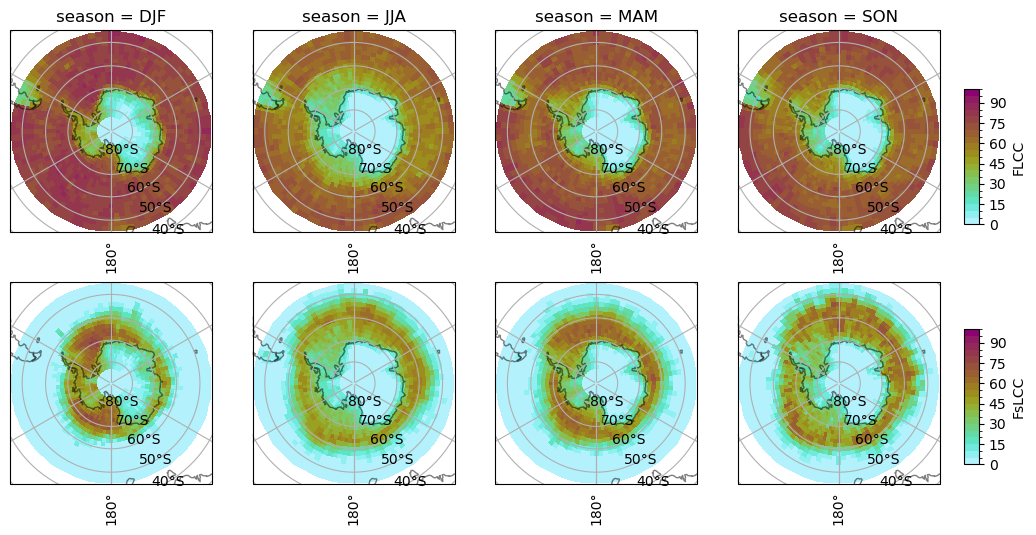

In [16]:
projection = fct.create_projection(hemisphere)
f, axsm = plt.subplots(nrows=2, 
                            ncols=4, 
                            subplot_kw={'projection': projection}, 
                            figsize=[12, 6], sharex=True, sharey=True)
for ax in axsm.flatten():
    fct.setup_axes(ax, hemisphere, lat_extent)
    
cmap = cm.hawaii_r 
levels = np.arange(0,105,5.)
norm = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=False)

i = 0

for ax, season in zip(axsm.flatten()[i * 4: (i + 1) * 4 + 1], flcc.season):
    if i == 0:
        sub_title = f'season = {season.values}'
        ax.set_title(sub_title)
        
    val = (flcc*100).sel(lat=slice(45,90)) if hemisphere == 'NH' else (flcc*100).sel(lat=slice(-90,-45))
    cf1 = ax.pcolormesh(val.lon, val.lat, (val.where(~np.isnan(val))).sel(season=season), 
                            transform=ccrs.PlateCarree(), 
                            cmap=cmap, 
                            norm=norm)
cbaxes = f.add_axes([0.92, 0.55, 0.0125, 0.225])
cb_label = 'FLCC'
extend = None
plt.colorbar(cf1, cax=cbaxes, shrink=0.5,extend=extend, orientation='vertical', label=cb_label)
        
i = 1
for ax, season in zip(axsm.flatten()[i * 4: (i + 1) * 4 + 1], fslcc.season):
    if i == 1:
        sub_title = f'season = {season.values}'
        
        val = (fslcc*100).sel(lat=slice(45,90)) if hemisphere == 'NH' else (fslcc*100).sel(lat=slice(-90,-45))
        cf = ax.pcolormesh(val.lon, val.lat, (val.where(~np.isnan(val))).sel(season=season), 
                            transform=ccrs.PlateCarree(), 
                            cmap=cmap, 
                            norm=norm)
        
cbaxes = f.add_axes([0.92, 0.15, 0.0125, 0.225])
cb_label = 'FsLCC'
extend = None
plt.colorbar(cf, cax=cbaxes, shrink=0.5,extend=extend, orientation='vertical', label=cb_label)

## Save CloudSat file

In [17]:
# model = 'IPSL-CM6A-LR'
# variable_id = ['areacella']
# cmip_file_in = glob(f'{cmip_in}/{model}/{variable_id[0]}_fx_*{model}*.nc')

# ds_cmip = xr.open_mfdataset(cmip_file_in)

# # Shift longitude to be from -180 to 180
# ds_cmip = ds_cmip.assign_coords(lon=(((ds_cmip['lon'] + 180) % 360) - 180)).sortby('lon')
# SH = ds_cmip.sel(lat=slice(-90,-45))
# NH = ds_cmip.sel(lat=slice(45,90))
# ds_cmip = xr.concat([SH, NH], 'lat')

# # SH = ds_cs.sel(lat=slice(-90,-45))
# # NH = ds_cs.sel(lat=slice(45,90))     
# # ds_cs = xr.concat([SH, NH], 'lat')

# # SH = ds_cs_orig.sel(lat=slice(-90,-45))
# # NH = ds_cs_orig.sel(lat=slice(45,90))     
# # ds_cs_orig = xr.concat([SH, NH], 'lat')
# SH = ds_cs_all.sel(lat=slice(-90,-45))
# NH = ds_cs_all.sel(lat=slice(45,90))     
# ds_cs_all = xr.concat([SH, NH], 'lat')

# SH = ds_cs_orig_all.sel(lat=slice(-90,-45))
# NH = ds_cs_orig_all.sel(lat=slice(45,90))
# ds_cs_orig_all = xr.concat([SH, NH], 'lat')

# ds_dict= {'orig': xr.merge([ds_cs_orig_all['n_lcc'], ds_cs_orig_all['n_cld'], ds_cs_orig_all['n_obs'], ds_cmip]),
#           'lcc_sf': xr.merge([ds_cs_orig_all['n_sf_lcc_snow'], ds_cmip]),
#         #   'orig': xr.merge([ds_cs_orig['n_lcc'], ds_cs_orig['n_cld'], ds_cs_orig['n_obs'], ds_cmip]),
#         #   'lcc_sf': xr.merge([ds_cs_orig['n_sf_lcc_snow'], ds_cmip]),
#           'lcc_2t': xr.merge([ds_cs_all['n_lcc'], ds_cmip]),
#           '2t' : xr.merge([ds_cs_all['n_cld'], ds_cs_all['n_obs'], ds_cmip]),
#           'lcc_2t_sf': xr.merge([ds_cs_all['n_sf_lcc_snow'], ds_cmip]),
#           'lcc_2t_days': xr.merge([ds_cs_all['sf_avg_lcc_snow'], ds_cmip])}

# starty = 2007; endy = 2010
# counter = 0
# for stats, dataset in ds_dict.items():
#     # print(stats, dataset)
#     filename = f'cloudsat_250_{stats}_{starty}01_{endy}12.nc'
#     cs_file_out = os.path.join(cs_out, f'{stats}/{filename}')
    
#     if os.path.exists(cs_file_out):
#         dataset.to_netcdf(cs_file_out)
#         print('file written: {}'.format(cs_file_out))
#             #     print(f'{cs_file_out} is downloaded')
#             #     counter += 1
#             #     print(f'Have regridded in total: {counter} files')
#     else:
#         dataset.to_netcdf(cs_file_out)
#         print('file written: {}'.format(cs_file_out))



In [18]:
model = 'IPSL-CM5A2-INCA'
variable_id = ['areacella']
cmip_file_in = glob(f'{cmip_in}/{model}/{variable_id[0]}_fx_*{model}*.nc')

ds_cmip = xr.open_mfdataset(cmip_file_in)

ds_cmip = ds_cmip.assign_coords(lon=(((ds_cmip['lon'] + 180) % 360) - 180)).sortby('lon')

SH = ds_cmip.sel(lat=slice(-90,-45))
NH = ds_cmip.sel(lat=slice(45,90))
ds_cmip = xr.concat([SH, NH], 'lat')


In [19]:


# SH = cs_in_grid.sel(lat=slice(-90,-45))
# NH = cs_in_grid.sel(lat=slice(45,90))
# cs_in_grid = xr.concat([SH, NH], 'lat')

# SH = cs_in_grid_orig.sel(lat=slice(-90,-45))
# NH = cs_in_grid_orig.sel(lat=slice(45,90))
# cs_in_grid_orig = xr.concat([SH, NH], 'lat')



In [20]:
SH = ds_cs_all.sel(lat=slice(-90,-45))
NH = ds_cs_all.sel(lat=slice(45,90))
cs_in_grid_all = xr.concat([SH, NH], 'lat')

SH = ds_cs_orig_all.sel(lat=slice(-90,-45))
NH = ds_cs_orig_all.sel(lat=slice(45,90))
cs_in_grid_orig_all = xr.concat([SH, NH], 'lat')


In [21]:
fslcc = (ds_cs_all['n_lcc']/ds_cs_orig_all['n_obs']).groupby('time.season').mean('time',skipna=True).fillna(0.)
flcc = (ds_cs_orig_all['n_lcc']/ds_cs_orig_all['n_obs']).groupby('time.season').mean('time',skipna=True).fillna(0.)

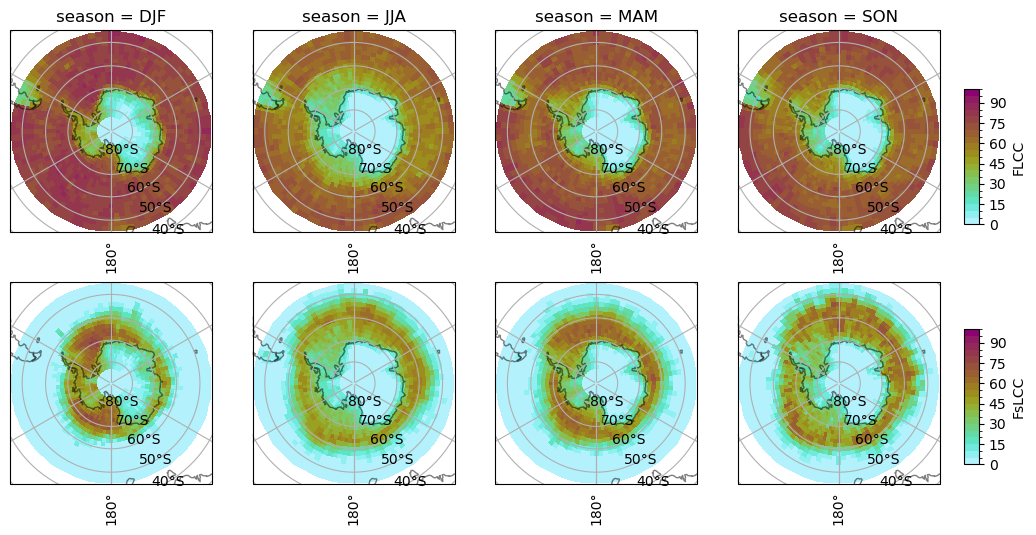

In [22]:
projection = fct.create_projection(hemisphere)
f, axsm = plt.subplots(nrows=2, 
                            ncols=4, 
                            subplot_kw={'projection': projection}, 
                            figsize=[12, 6], sharex=True, sharey=True)
for ax in axsm.flatten():
    fct.setup_axes(ax, hemisphere, lat_extent)
    
cmap = cm.hawaii_r 
levels = np.arange(0,105,5.)
norm = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=False)

i = 0

for ax, season in zip(axsm.flatten()[i * 4: (i + 1) * 4 + 1], flcc.season):
    if i == 0:
        sub_title = f'season = {season.values}'
        ax.set_title(sub_title)
        
    val = (flcc*100).sel(lat=slice(45,90)) if hemisphere == 'NH' else (flcc*100).sel(lat=slice(-90,-45))
    cf1 = ax.pcolormesh(val.lon, val.lat, (val.where(~np.isnan(val))).sel(season=season), 
                            transform=ccrs.PlateCarree(), 
                            cmap=cmap, 
                            norm=norm)
cbaxes = f.add_axes([0.92, 0.55, 0.0125, 0.225])
cb_label = 'FLCC'
extend = None
plt.colorbar(cf1, cax=cbaxes, shrink=0.5,extend=extend, orientation='vertical', label=cb_label)
        
i = 1
for ax, season in zip(axsm.flatten()[i * 4: (i + 1) * 4 + 1], fslcc.season):
    if i == 1:
        sub_title = f'season = {season.values}'
        
        val = (fslcc*100).sel(lat=slice(45,90)) if hemisphere == 'NH' else (fslcc*100).sel(lat=slice(-90,-45))
        cf = ax.pcolormesh(val.lon, val.lat, (val.where(~np.isnan(val))).sel(season=season), 
                            transform=ccrs.PlateCarree(), 
                            cmap=cmap, 
                            norm=norm)
        
cbaxes = f.add_axes([0.92, 0.15, 0.0125, 0.225])
cb_label = 'FsLCC'
extend = None
plt.colorbar(cf, cax=cbaxes, shrink=0.5,extend=extend, orientation='vertical', label=cb_label)

In [23]:


ds_dict= {'orig': xr.merge([cs_in_grid_orig_all['n_lcc'], cs_in_grid_orig_all['n_cld'], cs_in_grid_orig_all['n_obs'], ds_cmip]),
          'lcc_sf': xr.merge([cs_in_grid_orig_all['n_sf_lcc_snow'], ds_cmip]),
        #   'orig': xr.merge([cs_in_grid_orig['n_lcc'], cs_in_grid_orig['n_cld'], cs_in_grid_orig['n_obs'], ds_cmip]),
        #   'lcc_sf': xr.merge([cs_in_grid_orig['n_sf_lcc_snow'], ds_cmip]),
          'lcc_2t': xr.merge([cs_in_grid_all['n_lcc'], ds_cmip]),
          '2t' : xr.merge([cs_in_grid_all['n_cld'], cs_in_grid_all['n_obs'],ds_cmip]),
          'lcc_2t_sf': xr.merge([cs_in_grid_all['n_sf_lcc_snow'], ds_cmip]),
          'lcc_2t_days': xr.merge([cs_in_grid_all['sf_avg_lcc_snow'], ds_cmip])}

starty = 2007; endy = 2010
counter = 0
for stats, dataset in ds_dict.items():
    # print(stats, dataset)
    filename = f'cloudsat_500_{stats}_{starty}01_{endy}12.nc'
    cs_file_out = os.path.join(cs_out, f'{stats}/{filename}')
    
    if os.path.exists(cs_file_out):
        dataset.to_netcdf(cs_file_out)
        print('file written: {}'.format(cs_file_out))
            #     print(f'{cs_file_out} is downloaded')
            #     counter += 1
            #     print(f'Have regridded in total: {counter} files')
    else:
        dataset.to_netcdf(cs_file_out)
        print('file written: {}'.format(cs_file_out))



file written: /mn/vann/franzihe/output/CS_ERA5_CMIP6/orig/cloudsat_500_orig_200701_201012.nc
file written: /mn/vann/franzihe/output/CS_ERA5_CMIP6/lcc_sf/cloudsat_500_lcc_sf_200701_201012.nc
file written: /mn/vann/franzihe/output/CS_ERA5_CMIP6/lcc_2t/cloudsat_500_lcc_2t_200701_201012.nc
file written: /mn/vann/franzihe/output/CS_ERA5_CMIP6/2t/cloudsat_500_2t_200701_201012.nc
file written: /mn/vann/franzihe/output/CS_ERA5_CMIP6/lcc_2t_sf/cloudsat_500_lcc_2t_sf_200701_201012.nc
file written: /mn/vann/franzihe/output/CS_ERA5_CMIP6/lcc_2t_days/cloudsat_500_lcc_2t_days_200701_201012.nc


In [24]:
orig = xr.open_dataset('/mn/vann/franzihe/output/CS_ERA5_CMIP6/orig/cloudsat_500_orig_200701_201012.nc')
lcc_2t =  xr.open_dataset('/mn/vann/franzihe/output/CS_ERA5_CMIP6/lcc_2t/cloudsat_500_lcc_2t_200701_201012.nc')

In [25]:
fslcc = (lcc_2t['n_lcc']/orig['n_obs']).groupby('time.season').mean('time',skipna=True).fillna(0.)
flcc = (orig['n_lcc']/orig['n_obs']).groupby('time.season').mean('time',skipna=True).fillna(0.)

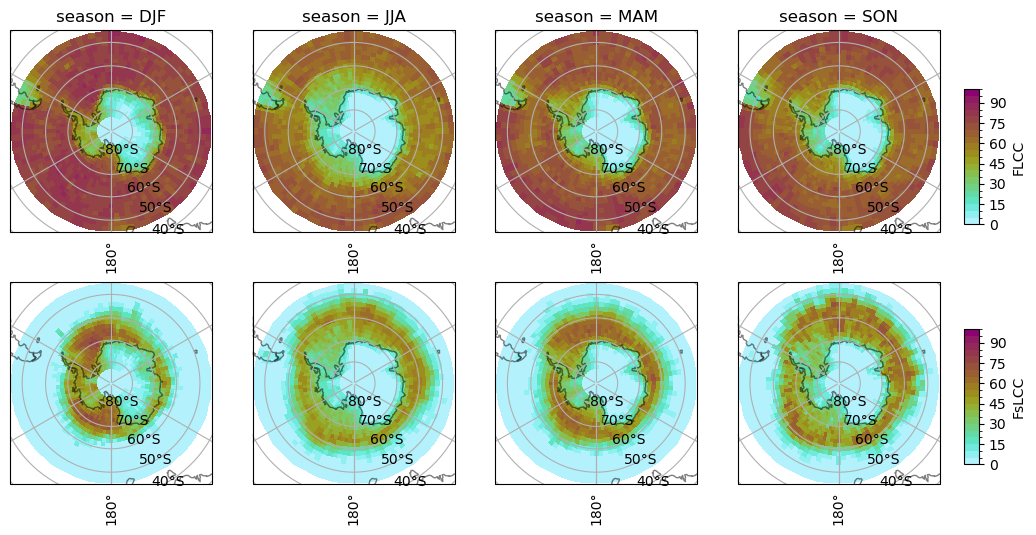

In [26]:
projection = fct.create_projection(hemisphere)
f, axsm = plt.subplots(nrows=2, 
                            ncols=4, 
                            subplot_kw={'projection': projection}, 
                            figsize=[12, 6], sharex=True, sharey=True)
for ax in axsm.flatten():
    fct.setup_axes(ax, hemisphere, lat_extent)
    
cmap = cm.hawaii_r 
levels = np.arange(0,105,5.)
norm = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=False)

i = 0

for ax, season in zip(axsm.flatten()[i * 4: (i + 1) * 4 + 1], flcc.season):
    if i == 0:
        sub_title = f'season = {season.values}'
        ax.set_title(sub_title)
        
    val = (flcc*100).sel(lat=slice(45,90)) if hemisphere == 'NH' else (flcc*100).sel(lat=slice(-90,-45))
    cf1 = ax.pcolormesh(val.lon, val.lat, (val.where(~np.isnan(val))).sel(season=season), 
                            transform=ccrs.PlateCarree(), 
                            cmap=cmap, 
                            norm=norm)
cbaxes = f.add_axes([0.92, 0.55, 0.0125, 0.225])
cb_label = 'FLCC'
extend = None
plt.colorbar(cf1, cax=cbaxes, shrink=0.5,extend=extend, orientation='vertical', label=cb_label)
        
i = 1
for ax, season in zip(axsm.flatten()[i * 4: (i + 1) * 4 + 1], fslcc.season):
    if i == 1:
        sub_title = f'season = {season.values}'
        
        val = (fslcc*100).sel(lat=slice(45,90)) if hemisphere == 'NH' else (fslcc*100).sel(lat=slice(-90,-45))
        cf = ax.pcolormesh(val.lon, val.lat, (val.where(~np.isnan(val))).sel(season=season), 
                            transform=ccrs.PlateCarree(), 
                            cmap=cmap, 
                            norm=norm)
        
cbaxes = f.add_axes([0.92, 0.15, 0.0125, 0.225])
cb_label = 'FsLCC'
extend = None
plt.colorbar(cf, cax=cbaxes, shrink=0.5,extend=extend, orientation='vertical', label=cb_label)


<img src="https://drive.google.com/uc?id=1zb0LHvipx8JOXLLrCxzYToJM7eNK4eaw"  height="100" />
<img src="https://reliance.rohub.org/static/media/Reliance-logo.433dc2e9.png"  height="100" />

<img src="https://www.uio.no/vrtx/decorating/resources/dist/src2/images/footer/uio-logo-en.svg"  height="100" />
<img src="https://erc.europa.eu/sites/default/files/logo_0.png"  height="100" />
